In [49]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [50]:
import os

noteboook_path = '/content/drive/MyDrive/Capstone'
os.chdir(noteboook_path) 

# Connect to GCP SQL Server

In [5]:
# gcloud login and check the DB
!gcloud auth login
!gcloud config set project high-risk-activity-cs
!gcloud sql instances describe berkeleycs          

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=5ojIM4V2go8uLU4OkLs6BLSwwyQVKL&prompt=consent&access_type=offline&code_challenge=-hFiT0fiw2F5_dUL2Kg0f2h_f2X1R9joahioa1O80sY&code_challenge_method=S256

Enter verification code: 4/1AX4XfWhnL6_IwMCOGT0D8km0pYCTbZ_zYiiyYDGdJm58it5_LK0OUpZAOYg

You are now logged in as [lexiejia77@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].
backendType: SECOND_GEN
connectionName: high-risk-activit

In [6]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy
# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="high-risk-activity-cs:us-central1:berkeleycs"=tcp:3306 &
!sleep 30s

--2021-11-10 01:43:00--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 142.251.45.110, 2607:f8b0:4004:835::200e
Connecting to dl.google.com (dl.google.com)|142.251.45.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16638816 (16M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  15.87M  53.7MB/s    in 0.3s    

2021-11-10 01:43:00 (53.7 MB/s) - ‘cloud_sql_proxy’ saved [16638816/16638816]

nohup: appending output to 'nohup.out'


In [7]:
!cat nohup.out

2021/11/09 05:10:00 current FDs rlimit set to 1048576, wanted limit is 8500. Nothing to do here.
2021/11/09 05:10:00 invalid json file "/content/adc.json": open /content/adc.json: no such file or directory
2021/11/09 05:17:37 current FDs rlimit set to 1048576, wanted limit is 8500. Nothing to do here.
2021/11/09 05:17:37 invalid json file "/content/adc.json": open /content/adc.json: no such file or directory
2021/11/09 05:21:34 current FDs rlimit set to 1048576, wanted limit is 8500. Nothing to do here.
2021/11/09 05:21:34 invalid json file "/content/adc.json": open /content/adc.json: no such file or directory
2021/11/09 05:26:52 current FDs rlimit set to 1048576, wanted limit is 8500. Nothing to do here.
2021/11/09 05:26:52 using credential file for authentication; path="/content/adc.json"
2021/11/09 05:26:53 Listening on 127.0.0.1:3306 for high-risk-activity-cs:us-central1:berkeleycs
2021/11/09 05:26:53 Ready for new connections
2021/11/09 05:26:53 Generated RSA key in 82.38582ms
202

In [8]:
!pip install pymysql

     |████████████████████████████████| 43 kB 2.6 MB/s 


In [9]:
import pymysql
#打开数据库连接
conn = pymysql.connect(host='127.0.0.1', port=3306,user = "root",passwd = "GQNO1",db = "CMU42")

In [10]:
cur = conn.cursor()
sql = 'show tables from CMU42'
rows = cur.execute(sql)  # 返回执行成功的结果条数
print(f'There are totally {rows} tables in database CMU42')
for d in cur.fetchall():
    print(d)

There are totally 6 tables in database CMU42
('device',)
('email',)
('file',)
('http',)
('logon',)
('psychometric',)


# Load Data Table

In [11]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import random

In [12]:
def read_table(name, nums=None):
  if nums:
    sql = 'SELECT * FROM {} LIMIT {}'.format(name, nums)
  else:
    sql = 'SELECT * FROM {}'.format(name)
  cur.execute(sql)
  column=[col[0] for col in cur.description]
  data = cur.fetchall()
  data_df = pd.DataFrame(list(data)[1:],columns=column)

  return data_df

In [13]:
%time
device = read_table('device')
email = read_table('email')
file = read_table('file')
http = read_table('http', 100000)
logon = read_table('logon')
psychometric = read_table('psychometric')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


# Data Processing

In [95]:
def process_datetime(df, col_name, nums=None):
    df.sort_values(by = ['date','user'],axis=0,ascending=True,inplace=True)
    df.reset_index(drop=True, inplace=True)

    if nums: df = df[:nums]
        
    df.loc[:,'date'] = pd.to_datetime(df[col_name])

    df.loc[:,"year"] = df[col_name].dt.strftime("%Y")
    df.loc[:,"year_month"] = df[col_name].dt.strftime("%Y-%m")
    df.loc[:,"year_month_day"] = df[col_name].dt.strftime("%Y-%m-%d")
    df.loc[:,"weekday"] = df[col_name].map(lambda x: x.weekday() + 1)
    df.loc[:,"week"] = df.apply(lambda x: x.date.isocalendar()[1], axis=1)
    df.loc[:,"year_week"] = df.apply(lambda x: x.year + "-" + str(x.week), axis=1)

    return df
    

## device

In [96]:
device.head()

,id,date,user,pc,activity
0,{A0A0-E2AP42AI-3349MGEJ},04/29/2011 09:03:11,RUM0880,PC-8592,Connect\r
1,{A0A0-G2XK34WD-2974HJBU},01/22/2010 08:28:34,LOM0086,PC-9087,Disconnect\r
2,{A0A0-I1YC27HO-5597OQLD},05/11/2011 14:44:27,LCB0664,PC-3196,Connect\r
3,{A0A0-K2HL16PD-1176YUKO},08/30/2010 16:45:00,VIA0063,PC-2684,Disconnect\r
4,{A0A0-P4LI63RV-2292CAGI},05/06/2011 20:29:49,EIS0041,PC-1590,Connect\r


In [97]:
print("Total number of row: ", device.shape[0])
print("Total number of users: ", device.user.nunique())
print("Total number of pc: ", device.pc.nunique())
print("Activity types: ", device.activity.unique())

Total number of row:  405380
Total number of users:  265
Total number of pc:  971
Activity types:  ['Connect\r' 'Disconnect\r']


In [98]:
device_df = process_datetime(device.copy(), 'date', nums=100000)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [99]:
print("Data range: ", device_df.date.min(), 'to', device_df.date.max())
device_df.head()

Data range:  2010-01-02 07:21:06 to 2011-03-02 23:23:07


,id,date,user,pc,activity,year,year_month,year_month_day,weekday,week,year_week
0,{P7C1-Q7OU25KT-7749GTBB},2011-01-01 08:30:07,MOH0273,PC-6699,Connect\r,2011,2011-01,2011-01-01,6,52,2011-52
1,{D7A1-D9GM18LA-0303CYEB},2011-01-01 08:38:23,IKP0472,PC-3842,Connect\r,2011,2011-01,2011-01-01,6,52,2011-52
2,{L7A7-H7XZ86JL-9912VBMD},2011-01-01 08:38:43,MLM0950,PC-9787,Connect\r,2011,2011-01,2011-01-01,6,52,2011-52
3,{C2K8-A1YB14RA-8421KQBV},2011-01-01 08:49:06,MOH0273,PC-6699,Disconnect\r,2011,2011-01,2011-01-01,6,52,2011-52
4,{U1L7-E9RZ04JJ-7778YHFZ},2011-01-01 08:54:55,GZC0735,PC-8219,Connect\r,2011,2011-01,2011-01-01,6,52,2011-52


## logon

In [100]:
logon.head()

,id,date,user,pc,activity
0,{A0A0-C1MM33BW-3773CNHJ},12/22/2010 11:00:36,BKW0374,PC-0174,Logoff\r
1,{A0A0-E5EC85TY-7815ELYE},05/12/2010 16:19:00,TSM0363,PC-5735,Logoff\r
2,{A0A0-E8HT11XB-5139DZIV},03/17/2011 18:10:00,NRD0548,PC-4527,Logoff\r
3,{A0A0-G7HL70AA-4309NTST},09/08/2010 08:24:00,SSH0799,PC-0902,Logon\r
4,{A0A0-H6GU35UA-4638RSVH},03/17/2011 07:46:00,JBM0350,PC-9744,Logon\r


In [101]:
print("Total number of row: ", logon.shape[0])
print("Total number of users: ", logon.user.nunique())
print("Total number of pc: ", logon.pc.nunique())
print("Activity types: ", logon.activity.unique())

Total number of row:  854859
Total number of users:  1000
Total number of pc:  1003
Activity types:  ['Logoff\r' 'Logon\r']


In [102]:
logon_df = process_datetime(logon.copy(), 'date', nums=100000)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [103]:
print("Data range: ", logon_df.date.min(), 'to', logon_df.date.max())
logon_df.head()

Data range:  2010-01-02 06:49:00 to 2011-01-31 05:14:05


,id,date,user,pc,activity,year,year_month,year_month_day,weekday,week,year_week
0,{T5C9-Q1TI07KO-8475XOTM},2011-01-01 00:15:05,IBS0836,PC-6382,Logon\r,2011,2011-01,2011-01-01,6,52,2011-52
1,{R8Y0-U1JH87TJ-7792IUSF},2011-01-01 03:34:12,NAH0503,PC-8267,Logon\r,2011,2011-01,2011-01-01,6,52,2011-52
2,{Z3T2-M7JJ49OA-7140HDHU},2011-01-01 05:11:11,NAH0503,PC-8267,Logoff\r,2011,2011-01,2011-01-01,6,52,2011-52
3,{W5F3-W8RM93EM-9191IHLI},2011-01-01 06:52:00,NGF0157,PC-6056,Logon\r,2011,2011-01,2011-01-01,6,52,2011-52
4,{U4I1-Q3KQ24QR-5784LXUL},2011-01-01 07:01:00,NOB0181,PC-3446,Logon\r,2011,2011-01,2011-01-01,6,52,2011-52


## http

In [104]:
http.head()

,id,date,user,pc,url,content
0,{A0A0-A0AX82EQ-5467ARJE},10/18/2010 11:15:08,ZSB0649,PC-5343,http://pcworld.com/Alexandre_Banza/bokassa/bcg...,germany much good foundation themed agreed sti...
1,{A0A0-A0SS97LS-8786VADN},09/14/2010 13:58:02,SMW0084,PC-8396,http://picnik.com/Frederick_Delius/delius/serf...,47 725 specifically appear and 1957 after espe...
2,{A0A0-A0UM20YT-1502VXLJ},10/05/2010 15:11:04,ACC0042,PC-0908,http://livejournal.com/Red_River_Trails/kittso...,sheffield home perception placed alongside met...
3,{A0A0-A1CV75AG-6012XSEQ},03/11/2010 20:34:39,KMS0657,PC-4761,http://cnn.com/Chickasaw_Turnpike/roff/ubyvqnl...,novel renown references north cold inflicted d...
4,{A0A0-A2UB26ND-8223PMVY},02/05/2010 13:59:52,QOS0878,PC-2211,http://mywebsearch.com/Terra_Nova_Expedition/k...,casting intensified seijun photo effect inform...


In [105]:
print("Only top 10,000 rows are read from database")
print("Total number of row: ", http.shape[0])
print("Total number of users: ", http.user.nunique())
print("Total number of pc: ", http.pc.nunique())
print("content sample: ", http.content[random.randint(0, http.shape[0])])

Only top 10,000 rows are read from database
Total number of row:  99999
Total number of users:  1000
Total number of pc:  1000
content sample:  pay estate science left attracting chronicler i selling poverty analytically 1879 marriage lying possessions renouncing distance home tradition celebrity desire ridge saint independent eased recession society 21 198 cannot associated re nisgaa unilateral affair mixed vancouver commissioner indian 13 critical etricourt insurance thompson no division school leonards ht battery concluded new towards two fog western convictions upcoming warren sport day events


In [106]:
http_df = process_datetime(http.copy(), 'date', nums=100000)

In [107]:
print("Data range: ", http_df.date.min(), 'to', http_df.date.max())
http_df.head()

Data range:  2010-01-02 07:23:04 to 2011-05-16 21:02:14


,id,date,user,pc,url,content,year,year_month,year_month_day,weekday,week,year_week
0,{A0B3-Q3LX12QU-4339NZHP},2011-01-01 07:16:50,AJD0074,PC-3135,http://cbs.com/Imagism/repaus/pnyraqnejngpuvat...,coverage warm widespread cause antonio circle ...,2011,2011-01,2011-01-01,6,52,2011-52
1,{A0B8-A9OE90EL-3815TCXF},2011-01-01 08:38:45,OBH0499,PC-7989,http://doubleclick.com/Blackburn_Olympic_FC/et...,started forthcoming 30 drive over lengths just...,2011,2011-01,2011-01-01,6,52,2011-52
2,{A0Q3-E9AG94TE-3655NVWW},2011-01-01 09:14:55,HVB0037,PC-7979,http://ticketmaster.com/North_Road_football_gr...,square 200 22 substantially image police korn ...,2011,2011-01,2011-01-01,6,52,2011-52
3,{A0R6-I3WH86PY-5663GVKK},2011-01-01 10:27:33,TDS0984,PC-7088,http://td.com/History_of_the_National_Hockey_L...,wiped clear trying about correct field depth s...,2011,2011-01,2011-01-01,6,52,2011-52
4,{A0G9-X2JV60LI-9942RQIA},2011-01-01 11:22:20,RZC0746,PC-7500,http://ask.com/Malcolm_X/lumumba/angheruvxvatp...,10 fence caves two sight believed do locates t...,2011,2011-01,2011-01-01,6,52,2011-52


## email

Does this table only include the email received by users? or sent email also included?

In [108]:
email.head()

,id,date,user,pc,towho,cc,bcc,fromwho,size,attachments,content
0,{A0A0-A1LB18AQ-7995CBDH},03/24/2010 12:45:43,CHG0146,PC-0780,Gay.Ria.Cantu@dtaa.com,,,Cedric.Herrod.Gilliam@dtaa.com,37059,0,strained east obligation long wrought accordin...
1,{A0A0-A4LN60BU-2632YIYQ},04/19/2011 14:49:48,TET0621,PC-5252,Shana.Callie.Ferguson@dtaa.com;Barclay.Eaton.H...,,,Tyler.Eden.Talley@dtaa.com,14602,1,they one environment again after to found g4tv...
2,{A0A0-A4WE63BA-3556WQVD},09/14/2010 10:13:30,FDE0117,PC-1772,Emily.I.Perry@cox.net,,,FDE8847@yahoo.com,15804,0,fully technique lead life b coolest eventual f...
3,{A0A0-A9ZJ14CF-0543QFNK},09/30/2010 09:13:08,BWH0813,PC-5110,Blaze.Jakeem.Hahn@dtaa.com,Phelan.Dieter.Hendricks@dtaa.com;Steel.Orson.F...,,Brock.William.Hunter@dtaa.com,14858,2,instantly long d coordinated exploit long p ha...
4,{A0A0-B0FH86WV-2533YVSB},04/14/2011 16:54:09,IJM0444,PC-8734,Elton.Tyler.Richard@dtaa.com,Ian.Jonas.Morrow@dtaa.com,,Ian.Jonas.Morrow@dtaa.com,15330,0,3 formed bluish has estimated return moving ni...


In [109]:
print("Total number of row: ", email.shape[0])
print("Total number of users: ", email.user.nunique())
print("Total number of pc: ", email.pc.nunique())
print("content sample: ", email.content[random.randint(0, email.shape[0])])

Total number of row:  2629979
Total number of users:  1000
Total number of pc:  1000
content sample:  tied revealed his shoulder took ice month czech success february shot only minor approach 120 vetoed pace mentor gil loose consolidated mwvp due often rather lone indicate 2 name them or organization subsequently


<function matplotlib.pyplot.show>

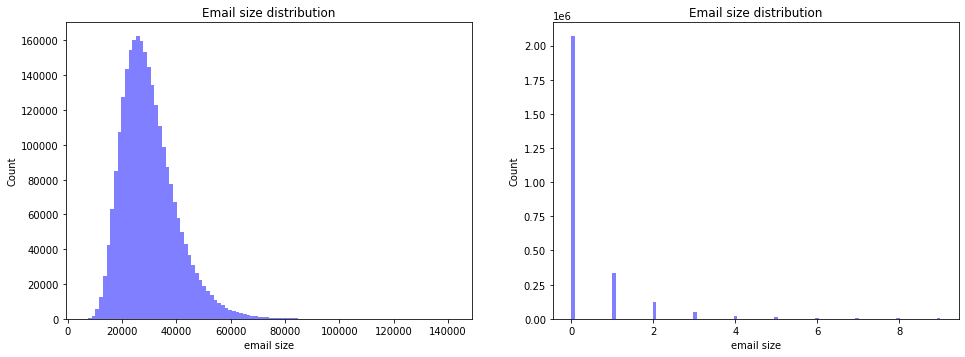

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,12))
plt.subplot(221)
plt.hist(email['size'], 100, facecolor='blue', alpha=0.5)
plt.xlabel('email size')
plt.ylabel('Count')
plt.title('Email size distribution')

plt.subplot(222)
plt.hist(email['attachments'], 100, facecolor='blue', alpha=0.5)
plt.xlabel('email size')
plt.ylabel('Count')
plt.title('Email size distribution')
plt.show

In [111]:
email_df = process_datetime(email.copy(), 'date', nums=100000)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [112]:
print("Data range: ", email_df.date.min(), 'to', email_df.date.max())
email_df.head()

Data range:  2010-01-02 07:11:45 to 2011-01-11 18:47:26


,id,date,user,pc,towho,cc,bcc,fromwho,size,attachments,content,year,year_month,year_month_day,weekday,week,year_week
0,{U2L5-T4TV50GA-0058PCQZ},2011-01-01 07:06:06,NGF0157,PC-6056,Eve.Isadora.Mckenzie@dtaa.com;Sasha.Rina.Huffm...,Libby.Rosalyn.Richard@dtaa.com;Nissim.Gil.Fren...,,Nissim.Gil.French@dtaa.com,43895,9,lengthy handicap part agent competition end sa...,2011,2011-01,2011-01-01,6,52,2011-52
1,{A3T6-X6TJ55FK-6978AMSJ},2011-01-01 07:21:21,MOH0273,PC-6699,Chandler.Ashton.Madden@dtaa.com,Zoe_Vang@boeing.com,Gage.Kaden.Odonnell@dtaa.com,Macaulay.Otto.Hopkins@dtaa.com,15948,0,ban 31 western left excessive convened critici...,2011,2011-01,2011-01-01,6,52,2011-52
2,{F7V1-B7HX93BD-1095VMRS},2011-01-01 07:35:06,TDS0984,PC-7088,Hillary.Ainsley.Mccormick@dtaa.com;John.Omar.L...,,,Tara.Dai.Stevenson@dtaa.com,25847,0,path form subjectively part world orders very ...,2011,2011-01,2011-01-01,6,52,2011-52
3,{D3T7-N7FL89HJ-9713UWXR},2011-01-01 07:38:13,TDS0984,PC-7088,YCE5@yahoo.com,Althea.I.Palmer@yahoo.com,,Tara_Stevenson@netzero.com,36241,0,wembley think hitler ashton possession possess...,2011,2011-01,2011-01-01,6,52,2011-52
4,{D3H0-A6RU30HO-5942QJYT},2011-01-01 07:41:04,NGF0157,PC-6056,Sasha.Rina.Huffman@dtaa.com,Nissim.Gil.French@dtaa.com,,Nissim.Gil.French@dtaa.com,28099,0,stylist archie hostile faster not brave determ...,2011,2011-01,2011-01-01,6,52,2011-52


## file

In [113]:
file.head()

,id,date,user,pc,filename,content
0,{A0A0-E3TU65HO-4056TBGQ},04/27/2011 05:46:08,AJF0370,PC-5910,6TAWLFOV.doc,D0-CF-11-E0-A1-B1-1A-E1 source compartments le...
1,{A0A0-M5LO52DM-9058EZYY},08/06/2010 17:48:54,JNJ0556,PC-0576,RDHVLL6V.doc,D0-CF-11-E0-A1-B1-1A-E1 1500 tailored or tasma...
2,{A0A0-O8ZY16AP-3225VVVP},04/29/2010 13:06:03,JDB0169,PC-7502,6PXW37HD.doc,D0-CF-11-E0-A1-B1-1A-E1 deputy dispatcher disc...
3,{A0A0-Q7NG65NN-9062QGBB},07/30/2010 17:42:35,SAA0999,PC-4559,E72ZO5H5.pdf,25-50-44-46-2D more society cannot lycoming ac...
4,{A0A0-W4MF49AQ-4030OMOF},03/30/2010 09:54:49,BMG0917,PC-6688,GKR36WBP.doc,D0-CF-11-E0-A1-B1-1A-E1 approved operations 15...


In [114]:
print("Total number of row: ", file.shape[0])
print("Total number of users: ", file.user.nunique())
print("Total number of pc: ", file.pc.nunique())
print("content sample: ", file.content[random.randint(0, file.shape[0])])

Total number of row:  445581
Total number of users:  264
Total number of pc:  956
content sample:  D0-CF-11-E0-A1-B1-1A-E1 diminished venture day ponni reached evolved aligning dominate purananuru adventurer dove capacity taken tiruchy but loss seizure detonation household guards poor worlds outlets denied improvised take infantry more sailors stores projects training penalized 1


In [ ]:
file_df = process_datetime(file.copy(), 'date', nums=100000)

In [116]:
print("Data range: ", file_df.date.min(), 'to', file_df.date.max())
file_df.head()

Data range:  2010-01-02 07:23:14 to 2011-02-24 23:22:24


,id,date,user,pc,filename,content,year,year_month,year_month_day,weekday,week,year_week
0,{Z0Z6-F2HS24ZL-4153CBHM},2011-01-01 08:33:26,MOH0273,PC-6699,5LR3NLX0.doc,D0-CF-11-E0-A1-B1-1A-E1 target dedicated fire ...,2011,2011-01,2011-01-01,6,52,2011-52
1,{N1J4-V3LF92XP-9136MTWS},2011-01-01 08:39:10,MOH0273,PC-6699,Y4T1HH70.doc,D0-CF-11-E0-A1-B1-1A-E1 fall slowed plantation...,2011,2011-01,2011-01-01,6,52,2011-52
2,{B1P0-M7EY28YC-6804DVUM},2011-01-01 09:17:54,MOH0273,PC-6699,GCSZQTCY.doc,D0-CF-11-E0-A1-B1-1A-E1 as surrounding center ...,2011,2011-01,2011-01-01,6,52,2011-52
3,{S1D3-D0ZC83PK-2967EWFI},2011-01-01 09:36:23,MLM0950,PC-9787,CZRJU8DU.txt,33-36-42-32 his secured were directions 25000 ...,2011,2011-01,2011-01-01,6,52,2011-52
4,{G3W3-C4OY90ET-9847MLSG},2011-01-01 09:43:23,MOH0273,PC-6699,P5H80RM4.doc,D0-CF-11-E0-A1-B1-1A-E1 near snow well experts...,2011,2011-01,2011-01-01,6,52,2011-52


## psychometric

In [117]:
psychometric.head()

,employee_name,user_id,O,C,E,A,N


In [118]:
print("Total number of row: ", psychometric.shape[0])
print("Total number of users: ", psychometric.user_id.nunique())

Total number of row:  0
Total number of users:  0


## Insider

In [119]:
insiders = pd.read_csv('insiders.csv')
insiders_sub = insiders[insiders.dataset == 4.2]
insiders_sub

,dataset,scenario,details,user,start,end
8,4.2,1,r4.2-1-AAM0658.csv,AAM0658,10/23/2010 01:34:19,10/29/2010 05:23:28
9,4.2,1,r4.2-1-AJR0932.csv,AJR0932,09/10/2010 19:12:01,09/18/2010 02:02:51
10,4.2,1,r4.2-1-BDV0168.csv,BDV0168,07/30/2010 19:56:44,08/10/2010 05:16:41
11,4.2,1,r4.2-1-BIH0745.csv,BIH0745,07/13/2010 20:15:23,07/13/2010 21:20:44
12,4.2,1,r4.2-1-BLS0678.csv,BLS0678,09/21/2010 01:16:22,09/30/2010 04:48:19
...,...,...,...,...,...,...
73,4.2,3,r4.2-3-JGT0221.csv,JGT0221,07/15/2010 09:43:23,07/16/2010 19:33:29
74,4.2,3,r4.2-3-JLM0364.csv,JLM0364,04/28/2011 09:50:07,04/29/2011 20:04:27
75,4.2,3,r4.2-3-JTM0223.csv,JTM0223,07/22/2010 07:27:46,07/23/2010 18:01:20
76,4.2,3,r4.2-3-MPM0220.csv,MPM0220,11/04/2010 08:59:55,11/05/2010 19:29:06


In [120]:
print("Total number of row: ", insiders_sub.shape[0])
print("Total number of users: ", insiders_sub.user.nunique())
insiders_sub.groupby('scenario').user.count().reset_index()

Total number of row:  70
Total number of users:  70


,scenario,user
0,1,30
1,2,30
2,3,10


In [121]:
insiders_sub.loc[:,'start'] = pd.to_datetime(insiders_sub['start'])
insiders_sub.loc[:,'end'] = pd.to_datetime(insiders_sub['end'])
print("Start date range: ", insiders_sub.start.min(), 'to', insiders_sub.start.max())

Start date range:  2010-06-10 07:54:10 to 2011-04-28 09:50:07


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Feature Engineering

## logon

### Number of logon after work hours

In [122]:
logon_df.loc[:,"hour"] = logon_df['date'].dt.strftime("%H") 
logon_df["hour"] = logon_df["hour"].astype('int')

logon_act_df = logon_df[logon_df['activity'] == 'Logon\r']

Plot number of logon each hour during the day

Text(0, 0.5, 'Number of logon')

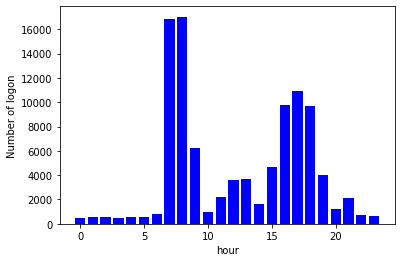

In [123]:
tmp = logon_df.groupby('hour').id.count().reset_index()
plt.bar(tmp['hour'], tmp['id'], color="blue")
plt.xlabel('hour')
plt.ylabel('Number of logon')

Plot number of logon each hour during the week

Text(0, 0.5, 'Number of logon')

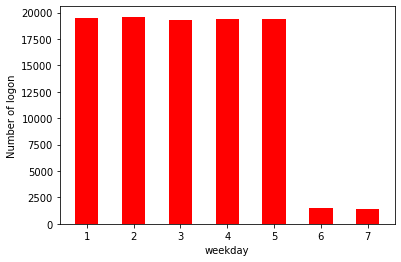

In [124]:
tmp = logon_df.groupby('weekday').id.count().reset_index()
plt.bar(tmp['weekday'], tmp['id'], width=0.5, color="red")
plt.xlabel('weekday')
plt.ylabel('Number of logon')

Compute the number of logon after work hours by user by time granularity (session/day/week)

In [125]:
logon_after_work = logon_act_df[(logon_act_df['weekday'] <= 5) & ((logon_act_df['hour']<7) | (logon_act_df['hour']>19))]

logon_after_work_week = logon_after_work.groupby(['user', 'year_week'])['id'].agg([('logon_num_work', 'count')]).reset_index()
logon_after_work_day = logon_after_work.groupby(['user', 'year_month_day'])['id'].agg([('logon_num_work', 'count')]).reset_index()
logon_after_work_day.head()

,user,year_month_day,logon_num_work
0,ACC0042,2010-01-04,1
1,ACC0042,2010-01-05,3
2,ACC0042,2010-01-06,2
3,ACC0042,2010-01-07,2
4,ACC0042,2010-01-08,2


Compute the number of logon on weekend & holiday by user by time granularity (session/day/week) \\
**Holiday data needed!**

In [126]:
logon_on_weekend = logon_act_df[logon_act_df['weekday']>=6]

logon_on_weekend_week = logon_on_weekend.groupby(['user', 'year_week'])['id'].agg([('logon_num_weekend', 'count')]).reset_index()
logon_on_weekend_day = logon_on_weekend.groupby(['user', 'year_month_day'])['id'].agg([('logon_num_weekend', 'count')]).reset_index()
logon_on_weekend_day.head()

,user,year_month_day,logon_num_weekend
0,ABC0174,2010-01-02,2
1,ABC0174,2010-01-09,2
2,ABC0174,2010-01-17,2
3,ABC0174,2010-01-23,1
4,ABC0174,2010-01-30,2


## email

### Email size

Compute the mean and std of email size by user by time granularity (session/day/week)

In [127]:
email_size_week = email_df.groupby(['user', 'year_week'])['size'].agg([("email_size_mean", "mean"),
                                                        ( "email_size_std", "std")]).reset_index()
email_size_day = email_df.groupby(['user', 'year_month_day'])['size'].agg([("email_size_mean", "mean"),
                                                        ( "email_size_std", "std")]).reset_index()
email_size_day.head()

,user,year_month_day,email_size_mean,email_size_std
0,AAE0190,2010-01-04,31523.428571,10815.679400
1,AAE0190,2010-01-05,27350.153846,6619.798497
2,AAE0190,2010-01-06,38046.214286,15557.216110
3,AAE0190,2010-01-07,33902.214286,10121.845348
4,AAE0190,2010-01-08,30818.230769,9142.573563


### Number of email sent

Compute number of emails sent by user by time granularity (session/day/week)

In [128]:
email_send_week = email_df.groupby(['user', 'year_week'])['id'].agg([('email_send_cnt', 'count')]).reset_index()
email_send_day = email_df.groupby(['user', 'year_month_day'])['id'].agg([('email_send_cnt', 'count')]).reset_index()
email_send_day.head()

,user,year_month_day,email_send_cnt
0,AAE0190,2010-01-04,14
1,AAE0190,2010-01-05,13
2,AAE0190,2010-01-06,14
3,AAE0190,2010-01-07,14
4,AAE0190,2010-01-08,13


## file

### Number of file activities

In [129]:
tmp = file_df.groupby(['filename']).id.count().reset_index()
if tmp[tmp.id>1].shape[0] == 0:
    print('No repeating filename found')

No repeating filename found


Compute the number of file activities by user by time granularity (session/day/week)

In [130]:
file_act_week = file_df.groupby(['user', 'year_week'])['id'].agg([('file_act', 'count')]).reset_index()
file_act_day = file_df.groupby(['user', 'year_month_day'])['id'].agg([('file_act', 'count')]).reset_index()
file_act_day.head()

,user,year_month_day,file_act
0,AAF0535,2010-01-05,1
1,AAF0535,2010-01-06,5
2,AAF0535,2010-01-07,1
3,AAF0535,2010-01-08,3
4,AAF0535,2010-01-12,2


Compute the number of file activities on shared PCs by user by time granularity (session/day/week)

In [131]:
shared_pc_df = file_df.groupby(['pc'])['user'].count().reset_index()
shared_pc = shared_pc_df[shared_pc_df.user>1].pc.tolist()

shared_pc_act = file_df[file_df.pc.isin(shared_pc)]
shared_pc_act_week = shared_pc_act.groupby(['user', 'year_week'])['id'].agg([('shared_pc_act', 'count')]).reset_index()
shared_pc_act_day = shared_pc_act.groupby(['user', 'year_month_day'])['id'].agg([('shared_pc_act', 'count')]).reset_index()
shared_pc_act_day.head()

,user,year_month_day,shared_pc_act
0,AAF0535,2010-01-05,1
1,AAF0535,2010-01-06,5
2,AAF0535,2010-01-07,1
3,AAF0535,2010-01-08,3
4,AAF0535,2010-01-12,2


## Integrate output

Generate the full permutation of date and user as the 'primary table' of the output table. \\
User set is extracted from logon file.

In [94]:
from itertools import product


start_dt = '2010-01-01'
end_dt = '2010-12-31'

date_list = list(pd.date_range(start=start_dt, end=end_dt))
user_list = logon_df.user.unique().tolist()

date_column = [i for i, j in product(date_list, user_list)]
user_column = [j for i, j in product(date_list, user_list)]
permutation = {"date": date_column, "user": user_column}
permutation_df = pd.DataFrame(permutation)

permutation_df.loc[:,"year"] = permutation_df["date"].dt.strftime("%Y")
permutation_df.loc[:,"year_month"] = permutation_df["date"].dt.strftime("%Y-%m")
permutation_df.loc[:,"year_month_day"] = permutation_df["date"].dt.strftime("%Y-%m-%d")
permutation_df.loc[:,"weekday"] = permutation_df["date"].map(lambda x: x.weekday() + 1)
permutation_df.loc[:,"week"] = permutation_df.apply(lambda x: x.date.isocalendar()[1], axis=1)
permutation_df.loc[:,"year_week"] = permutation_df.apply(lambda x: x.year + "-" + str(x.week), axis=1)
permutation_df

,date,user,year,year_month,year_month_day,weekday,week,year_week
0,2010-01-01,IBS0836,2010,2010-01,2010-01-01,5,53,2010-53
1,2010-01-01,NAH0503,2010,2010-01,2010-01-01,5,53,2010-53
2,2010-01-01,NGF0157,2010,2010-01,2010-01-01,5,53,2010-53
3,2010-01-01,NOB0181,2010,2010-01,2010-01-01,5,53,2010-53
4,2010-01-01,AJD0074,2010,2010-01,2010-01-01,5,53,2010-53
...,...,...,...,...,...,...,...,...
364995,2010-12-31,DIB0285,2010,2010-12,2010-12-31,5,52,2010-52
364996,2010-12-31,MTT0901,2010,2010-12,2010-12-31,5,52,2010-52
364997,2010-12-31,HRD0635,2010,2010-12,2010-12-31,5,52,2010-52
364998,2010-12-31,AAM0658,2010,2010-12,2010-12-31,5,52,2010-52


In [144]:
insiders_sub.loc[:,'start'] = pd.to_datetime(insiders_sub['start'])
insiders_sub.loc[:, 'start_year_week'] = insiders_sub.apply(lambda x: x.start.strftime("%Y")+ "-" + str(x.start.isocalendar()[1]), axis=1)
insiders_sub.loc[:,'end'] = pd.to_datetime(insiders_sub['end'])
insiders_sub.loc[:, 'end_year_week'] = insiders_sub.apply(lambda x: x.end.strftime("%Y")+ "-" + str(x.end.isocalendar()[1]), axis=1)
insiders_sub

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,dataset,scenario,details,user,start,end,start_year_week,end_year_week
8,4.2,1,r4.2-1-AAM0658.csv,AAM0658,2010-10-23 01:34:19,2010-10-29 05:23:28,2010-42,2010-43
9,4.2,1,r4.2-1-AJR0932.csv,AJR0932,2010-09-10 19:12:01,2010-09-18 02:02:51,2010-36,2010-37
10,4.2,1,r4.2-1-BDV0168.csv,BDV0168,2010-07-30 19:56:44,2010-08-10 05:16:41,2010-30,2010-32
11,4.2,1,r4.2-1-BIH0745.csv,BIH0745,2010-07-13 20:15:23,2010-07-13 21:20:44,2010-28,2010-28
12,4.2,1,r4.2-1-BLS0678.csv,BLS0678,2010-09-21 01:16:22,2010-09-30 04:48:19,2010-38,2010-39
...,...,...,...,...,...,...,...,...
73,4.2,3,r4.2-3-JGT0221.csv,JGT0221,2010-07-15 09:43:23,2010-07-16 19:33:29,2010-28,2010-28
74,4.2,3,r4.2-3-JLM0364.csv,JLM0364,2011-04-28 09:50:07,2011-04-29 20:04:27,2011-17,2011-17
75,4.2,3,r4.2-3-JTM0223.csv,JTM0223,2010-07-22 07:27:46,2010-07-23 18:01:20,2010-29,2010-29
76,4.2,3,r4.2-3-MPM0220.csv,MPM0220,2010-11-04 08:59:55,2010-11-05 19:29:06,2010-44,2010-44


In [157]:
output_df_week = permutation_df[['year_week', 'user']]

output_df_week = output_df_week.merge(logon_after_work_week, how='left', on=['user', 'year_week'])
output_df_week = output_df_week.merge(logon_on_weekend_week, how='left', on=['user', 'year_week'])

output_df_week = output_df_week.merge(email_size_week, how='left', on=['user', 'year_week'])
output_df_week = output_df_week.merge(email_send_week, how='left', on=['user', 'year_week'])

output_df_week = output_df_week.merge(file_act_week, how='left', on=['user', 'year_week'])
output_df_week = output_df_week.merge(shared_pc_act_week, how='left', on=['user', 'year_week'])

output_df_week = output_df_week.merge(insiders_sub[['user', 'start_year_week', 'end_year_week']], how='left', on=['user'])
output_df_week['if_risk'] = output_df_week.apply(lambda x: 
                                                 True if x.start_year_week and str(x.end_year_week) >= str(x.year_week) >= str(x.start_year_week) else False, axis=1)

,year_week,user,logon_num_work,logon_num_weekend,email_size_mean,email_size_std,email_send_cnt,file_act,shared_pc_act,start_year_week,end_year_week,if_risk
0,2010-53,IBS0836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2010-53,NAH0503,NaN,1.0,30442.933333,10303.076804,15.0,NaN,NaN,NaN,NaN,False
2,2010-53,NGF0157,NaN,2.0,23592.777778,6954.613141,9.0,NaN,NaN,NaN,NaN,False
3,2010-53,NOB0181,NaN,5.0,25435.500000,10214.407252,6.0,4.0,4.0,NaN,NaN,False
4,2010-53,AJD0074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
364995,2010-52,DIB0285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-30,2010-37,False
364996,2010-52,MTT0901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
364997,2010-52,HRD0635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
364998,2010-52,AAM0658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-42,2010-43,False


In [161]:
del output_df_week['start_year_week'], output_df_week['end_year_week']

In [165]:
output_df_week.fillna(0, inplace=True)
output_df_week

,year_week,user,logon_num_work,logon_num_weekend,email_size_mean,email_size_std,email_send_cnt,file_act,shared_pc_act,if_risk
0,2010-53,IBS0836,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False
1,2010-53,NAH0503,0.0,1.0,30442.933333,10303.076804,15.0,0.0,0.0,False
2,2010-53,NGF0157,0.0,2.0,23592.777778,6954.613141,9.0,0.0,0.0,False
3,2010-53,NOB0181,0.0,5.0,25435.500000,10214.407252,6.0,4.0,4.0,False
4,2010-53,AJD0074,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...
364995,2010-52,DIB0285,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False
364996,2010-52,MTT0901,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False
364997,2010-52,HRD0635,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False
364998,2010-52,AAM0658,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False


In [238]:
risk_ratio = output_df_week[output_df_week.if_risk].shape[0]/output_df_week.shape[0]
print('There are ', round(risk_ratio*100,2), "% of risk cases in the model input dataset.")

There are  0.53 % of risk cases in the model input dataset.


# Model Selection

In [183]:
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform

Validation and test predictions of the select models

In [191]:
validation_predictions = {}
test_predictions = {}

## Logistic Regression

Split the dataset into training, validation, and test sets

In [184]:
label_encoder = LabelEncoder()
output_df_week["label"] = label_encoder.fit_transform(output_df_week["if_risk"].values) 

In [239]:
feature_list = ['logon_num_work', 'logon_num_weekend',
       'email_size_mean', 'email_size_std', 'email_send_cnt', 'file_act',
       'shared_pc_act']
label = ['if_risk']

X = output_df_week[feature_list]
y = output_df_week[label]

X, X_test, y, y_test = train_test_split(X, y, test_size=1/4, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, 
                                                  random_state=0)

Train the logistic regreesion model and find the best hyperparamter via Random Search

In [240]:
X_LR = np.concatenate((X_train, X_val), axis=0)
y_LR = np.concatenate((y_train, y_val), axis=0)
test_fold = -np.ones(X_LR.shape[0]) 
test_fold[-len(y_val):] = 0
ps = PredefinedSplit(test_fold=test_fold)

In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

In [304]:
model_LR = LogisticRegression(
    solver='saga',
    max_iter=1e2, 
    tol=1e-2, 
    random_state=0)

distributions = dict(C=uniform(loc=0.01, scale=100), class_weight=[None, 'balanced']) 

n_iter = 20
RS = RandomizedSearchCV(
    model_LR, 
    distributions, 
    n_iter=n_iter,
    refit="accuracy",
    cv=ps, 
    scoring=["roc_auc", "accuracy", "precision"],
    random_state=0)

RS.fit(X_LR, y_LR.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100.0,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=0,
                                                solver='saga', tol=0.01,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb53fa59450>,
                                        'class_weight': [None, 'balanced']},
                  

In [308]:
RS.cv_results_

{'mean_fit_time': array([1.30648685, 1.30466056, 1.29945087, 3.88096213, 3.78996825,
        3.81678247, 3.89270687, 3.8991127 , 1.32412887, 3.91619468,
        1.31857252, 1.30596447, 1.29340553, 1.2777555 , 1.25716639,
        1.31754327, 3.8573277 , 1.30305219, 1.26732779, 1.25836515]),
 'mean_score_time': array([0.10791492, 0.09111404, 0.09474039, 0.09026408, 0.09068727,
        0.0903132 , 0.09120488, 0.09059072, 0.08972049, 0.08415318,
        0.09727407, 0.09353662, 0.09420514, 0.08840632, 0.08839417,
        0.09728003, 0.09149051, 0.09157634, 0.10001516, 0.09461355]),
 'mean_test_accuracy': array([0.04543562, 0.04543562, 0.04543562, 0.99481644, 0.99481644,
        0.99481644, 0.99481644, 0.99481644, 0.04543562, 0.99481644,
        0.04543562, 0.04543562, 0.04543562, 0.04543562, 0.04543562,
        0.04543562, 0.99481644, 0.04543562, 0.04543562, 0.04543562]),
 'mean_test_precision': array([0.00540096, 0.00540096, 0.00540096, 0.        , 0.        ,
        0.        , 0.       

In [305]:
best_models_LR = RS.cv_results_

df_LR = pd.DataFrame(index=["C", "class_weight", "accuracy", "roc_auc", "precision"])
for i in range(n_iter):
    df_LR['{}'.format(i)] = pd.Series(
        data=np.array(
            [
             best_models_LR['params'][i]['C'],
             best_models_LR['params'][i]['class_weight'],
             best_models_LR['mean_test_accuracy'][i],
             best_models_LR['mean_test_roc_auc'][i],
             best_models_LR['mean_test_precision'][i]
             ]
            )
        ).values
df_LR.loc['roc_auc'] = df_LR.loc['roc_auc'].astype('float')
df_LR.loc['accuracy'] = df_LR.loc['accuracy'].astype('float')
df_LR.loc['precision'] = df_LR.loc['precision'].astype('float')
df_LR.loc['C'] = df_LR.loc['C'].astype('float')
df_LR.sort_values(by=['accuracy'], axis=1, ascending=False, inplace=True)

## The number of models we keep
n_models = 5
df_LR = df_LR.iloc[:, :n_models]
clmns = df_LR.columns
for i in range(n_models):
    df_LR.rename(columns={clmns[i]:'LR_{}'.format(i)}, inplace=True)

    c = df_LR['LR_{}'.format(i)].loc['C']
    weight = df_LR['LR_{}'.format(i)].loc['class_weight']

    model = LogisticRegression(
        C=c,
        class_weight=weight,
        solver='saga',
        max_iter=1e2, 
        tol=1e-2, 
        random_state=0
        )
    
    model.fit(X_train, y_train.values.ravel())

    validation_predictions['LR_{}'.format(i)] = model.predict_proba(X_val)[:, 1]
    test_predictions['LR_{}'.format(i)] = model.predict_proba(X_test)[:, 1]

df_LR.to_csv('df_LR.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [306]:
df_LR

,LR_0,LR_1,LR_2,LR_3,LR_4
C,62.3664,43.7687,5.6813,38.3542,81.2269
class_weight,None,None,None,None,None
accuracy,0.994816,0.994816,0.994816,0.994816,0.994816
roc_auc,0.494687,0.494687,0.494687,0.494687,0.494687
precision,0,0,0,0,0


In [310]:
test = X_test.copy()
test['pred'] = model.predict(X_test)
test = pd.concat([test,y_test], axis=1)
test[test['pred'] == test['if_risk']]

,logon_num_work,logon_num_weekend,email_size_mean,email_size_std,email_send_cnt,file_act,shared_pc_act,pred,if_risk


# Keep notebook running!!!

In [ ]:
while True:pass